# Naive MLP to detect spam
Here: build the most basic solution that classifies emails.
We don't expect a good solution, just something that works so that we can implement changes later on, one at a time.

Naive ideas :
Word embedder : naive solution which consists of going through all the words in the file and assigning them the order in which they are encountered.
Classifier itself : MLP

It is also necessary to clean the data (transform to lowercase ...) but I describe that in detail later.

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd # conda install -c anaconda pandas

#Deep learning 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
import random
from sklearn.metrics import confusion_matrix

#Text processing
import tensorflow as tf # conda install -c conda-forge tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Familiarizing ourselves with the Tokenizer
A tokenizer converts a string, such as a sentence, into individual tokens. These may be words or numbers. The simplest tokenizer consists in separating a sentence into words.

In [2]:
text = "Here’s to the crazy ones, the misfits, the rebels, the troublemakers"
text.split() # python method

['Here’s',
 'to',
 'the',
 'crazy',
 'ones,',
 'the',
 'misfits,',
 'the',
 'rebels,',
 'the',
 'troublemakers']

There are several details to take into account. For example, whether to include punctuation and how to handle upper case letters. The tokenizer method from tensorflow.keras allows us to transform text into sequences.

In [6]:
#Tensorflow.keras method
#Tokenizer can handle spaces at start of string
text2 = [" Here’s to the crazy ones, the misfits, the rebels, the troublemakers"]
        # LIST containing our string, not the same thing I don't know why
tokenizer = Tokenizer(num_words=50, lower=True, char_level=False)
tokenizer.fit_on_texts(text2) 
sequences = tokenizer.texts_to_sequences(text2)
print(sequences)

[[2, 3, 1, 4, 5, 1, 6, 1, 7, 1, 8]]


Let's examine each command.

*fit_on_texts* updates the vocabulary of our tokenizer. Each word is assigned an index based on how frequent it appears in our text. So the most common word gets assigned 1, the second most common 2 and so on. The index 0 is reserved for padding.

We can define a limit to the size of our vocabulary, defined in the first line with *num_word=50*, which can allow us to filter out rare words. The tokenizer method filters out all punctuation by default, and *lower=True* converts all uppercase characters to lowercase. Setting *char_level=False* simply means we split at the level of words rather than at the level of characters.

*texts_to_sequences* transforms the given text into a sequence of indices, using the internal vocabulary of our tokenizer. Having the two commands be separate allows us to "train" our vocabulary on one text and convert any new text we want.

In [7]:
tokenizer.word_index

{'the': 1,
 'here’s': 2,
 'to': 3,
 'crazy': 4,
 'ones': 5,
 'misfits': 6,
 'rebels': 7,
 'troublemakers': 8}

# Load the data
Following the tutorial on https://towardsdatascience.com/nlp-spam-detection-in-sms-text-data-using-deep-learning-b8632db85cc8 to get something started.

In [2]:
url = "https://raw.githubusercontent.com/ThinhNguyendai/SMSSpamDetection/main/SMSSpamCollection" #Use the RAW one
messages = pd.read_csv(url, sep ='\t', names=["label", "message"])
messages[:3]

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...


In [3]:
messages.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [4]:
duplicatedRow = messages[messages.duplicated()]
print(duplicatedRow[:10])

    label                                            message
103   ham  As per your request 'Melle Melle (Oru Minnamin...
154   ham  As per your request 'Melle Melle (Oru Minnamin...
207   ham  As I entered my cabin my PA said, '' Happy B'd...
223   ham                             Sorry, I'll call later
326   ham                   No calls..messages..missed calls
339   ham                             Sorry, I'll call later
357  spam  Congratulations ur awarded 500 of CD vouchers ...
444   ham                             Sorry, I'll call later
533   ham                  Gudnite....tc...practice going on
655   ham                       Did u got that persons story


We have 5572 messages, 4825 of which are ham and 747 are spam. The dataset is **highly unbalanced, so we need to do something about it.**. We also have 403 duplicate messages.

There are many ways to handle unbalanced dataset, and it is worth exploring other ways than the one shown in the link. The author uses downsampling, which simply deletes observations from the class that is overrepresented.

In [5]:
ham_msg = messages[messages.label =='ham']
spam_msg = messages[messages.label=='spam']

In [6]:
ham_msg_df = ham_msg.sample(n = len(spam_msg), random_state = 704)
spam_msg_df = spam_msg
print(ham_msg_df.shape, spam_msg_df.shape)

(747, 2) (747, 2)


In [7]:
msg_df = pd.concat([ham_msg_df, spam_msg_df])
msg_df.reset_index(drop=True)

,label,message
0,ham,Maybe?! Say hi to and find out if got his ca...
1,ham,Jos ask if u wana meet up?
2,ham,I dont know oh. Hopefully this month.
3,ham,"Dear Hero,i am leaving to qatar tonite for an ..."
4,ham,No that just means you have a fat head
...,...,...
1489,spam,Want explicit SEX in 30 secs? Ring 02073162414...
1490,spam,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...
1491,spam,Had your contract mobile 11 Mnths? Latest Moto...
1492,spam,REMINDER FROM O2: To get 2.50 pounds free call...


In [8]:
msg_labels = (msg_df['label'].map({'ham': 0, 'spam': 1})).values
            # map creates a dataframe where we replace values
            # .values is to extract the values as an array
msg_labels

array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

In [9]:
# Split data into train and test
train_msg, test_msg, train_labels, test_labels = train_test_split(msg_df['message'],
                                                                  msg_labels,
                                                                  test_size=0.2,
                                                                  random_state=705)

In [10]:
print(len(train_msg))
print(len(test_msg))
print("\n")
print(train_msg)
print("\n")
print(train_labels)

1195
299


5039    Thanks for being there for me just to talk to ...
1122    Do you want 750 anytime any network mins 150 t...
1751                           Got it..mail panren paru..
1376                              We're finally ready fyi
3906    Do you want a new video handset? 750 anytime a...
                              ...                        
3562    Text BANNEDUK to 89555 to see! cost 150p texto...
5537    Want explicit SEX in 30 secs? Ring 02073162414...
1952    Haha... Really oh no... How? Then will they de...
4432       2mro i am not coming to gym machan. Goodnight.
2808    December only! Had your mobile 11mths+? You ar...
Name: message, Length: 1195, dtype: object


[0 1 0 ... 0 0 1]


In [11]:
#Tokenizer : turn words into integers
oov_tok = "<OOV>" # What to replace words that are not in the vocabulary with
vocab_size = 500 # Maximum number of words for tokenizer

tokenizer = Tokenizer(num_words = vocab_size,
                      char_level=False, # Work words by word
                      oov_token = oov_tok)
tokenizer.fit_on_texts(train_msg)

In [12]:
word_index = tokenizer.word_index
word_index

{'<OOV>': 1,
 'to': 2,
 'you': 3,
 'a': 4,
 'i': 5,
 'call': 6,
 'the': 7,
 'your': 8,
 'u': 9,
 'for': 10,
 'is': 11,
 'now': 12,
 'and': 13,
 '2': 14,
 'free': 15,
 'or': 16,
 'on': 17,
 'in': 18,
 'have': 19,
 'ur': 20,
 'txt': 21,
 'me': 22,
 'from': 23,
 '4': 24,
 'of': 25,
 'are': 26,
 'text': 27,
 'with': 28,
 'it': 29,
 'this': 30,
 'get': 31,
 'mobile': 32,
 'just': 33,
 'stop': 34,
 'no': 35,
 'my': 36,
 'only': 37,
 'reply': 38,
 'claim': 39,
 'will': 40,
 'send': 41,
 'out': 42,
 'so': 43,
 'if': 44,
 'that': 45,
 'be': 46,
 'we': 47,
 'our': 48,
 'prize': 49,
 'www': 50,
 'can': 51,
 'do': 52,
 'not': 53,
 'at': 54,
 'cash': 55,
 'but': 56,
 'won': 57,
 '150p': 58,
 'new': 59,
 't': 60,
 'win': 61,
 'msg': 62,
 '1': 63,
 'please': 64,
 'phone': 65,
 '50': 66,
 'who': 67,
 'uk': 68,
 'week': 69,
 'urgent': 70,
 'go': 71,
 'all': 72,
 'nokia': 73,
 'tone': 74,
 "i'm": 75,
 'service': 76,
 'when': 77,
 'min': 78,
 'what': 79,
 'know': 80,
 'want': 81,
 'r': 82,
 'by': 83,
 'c

In [13]:
len(word_index) # Importance of setting a max size of vocabulary here : many rare words

4194

In [14]:
# Sequencing and padding on training and testing 
max_len = 50 # Max number of tokens, used with truncating and padding
trunc_type = "post" # Truncates sequences of tokens that are longer than max_len, post=right side
padding_type = "post" # Pads AFTER (with post) if sequence is shorter than max_len

training_sequences = tokenizer.texts_to_sequences(train_msg)
training_padded = pad_sequences (training_sequences, maxlen = max_len,
                                 padding = padding_type, truncating = trunc_type)

testing_sequences = tokenizer.texts_to_sequences(test_msg)
testing_padded = pad_sequences(testing_sequences, maxlen = max_len,
                               padding = padding_type, truncating = trunc_type)

In [15]:
# Shape of train tensor
print('Shape of training tensor: ', training_padded.shape)
print('Shape of testing tensor: ', testing_padded.shape)

Shape of training tensor:  (1195, 50)
Shape of testing tensor:  (299, 50)


In [16]:
# Need to convert to torch tensors to feed into neural network
print(type(training_padded))
print(type(train_labels))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [17]:
X_train = torch.from_numpy(training_padded).float()
X_test = torch.from_numpy(testing_padded).float()
Y_train = torch.from_numpy(train_labels).float()
Y_test = torch.from_numpy(test_labels).float()

In [18]:
max_len # Number of input neurons

50

In [23]:
iters = 128

net = nn.Sequential(
    nn.Linear(max_len, 32),
    nn.ReLU(),
    nn.Linear(32, 32),
    nn.ReLU(),
    nn.Linear(32, 1),
    nn.Sigmoid(),
)
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=.01)

loss_history = [] #Per iteration
accuracy_history = []
accuracy_test_history = []
sensitivity_history = [] # True positive rate
specificity_history = [] # True negative rate

for i in range(iters): # Each iteration is on the full dataset here
    proba_pred = net(X_train)  # forward pass
    proba_pred = proba_pred.squeeze(-1)  # transform the 1-element vectors into scalars

    optimizer.zero_grad() # reset the gradients to 0
    loss = criterion(proba_pred, Y_train)
    loss_history.append(loss.item()) # .item() to turn it into a python number
    loss.backward()  # obtain the gradients with respect to the loss
    optimizer.step()  # perform one step of gradient descent

    with torch.no_grad():
        Y_pred = proba_pred > 0.5  # Binary label
        accuracy = (Y_train == Y_pred).float().mean()
        accuracy_history.append(accuracy.item())
            
    with torch.no_grad():
        proba_pred_test = net(X_test)
        proba_pred_test = proba_pred_test.squeeze(-1)
        Y_pred_test = proba_pred_test > 0.5
        
        tn, fp, fn, tp = confusion_matrix(Y_test, Y_pred_test).ravel()
        accuracy_test_history.append((tn+tp)/(tn+fp+fn+tp))
        sensitivity_history.append(tp/(tp+fn))
        specificity_history.append(tn/(tn+fp))
    
    print("Iteration {iter} done".format(iter=i+1))
    print("Training accuracy is equal to {trainAcc}".format(trainAcc=accuracy_history[-1]))
    print("Test accuracy is equal to {t}".format(t=accuracy_test_history[-1]))
    print("Sensitivity is equal to {t}".format(t=sensitivity_history[-1]))
    print("Specificity is equal to {t}".format(t=specificity_history[-1]))

Iteration 1 done
Training accuracy is equal to 0.4861924648284912
Test accuracy is equal to 0.4882943143812709
Sensitivity is equal to 0.013157894736842105
Specificity is equal to 0.9795918367346939
Iteration 2 done
Training accuracy is equal to 0.4920502007007599
Test accuracy is equal to 0.5551839464882943
Sensitivity is equal to 0.3157894736842105
Specificity is equal to 0.8027210884353742
Iteration 3 done
Training accuracy is equal to 0.5539748668670654
Test accuracy is equal to 0.5819397993311036
Sensitivity is equal to 0.9342105263157895
Specificity is equal to 0.21768707482993196
Iteration 4 done
Training accuracy is equal to 0.6100418567657471
Test accuracy is equal to 0.5351170568561873
Sensitivity is equal to 0.993421052631579
Specificity is equal to 0.061224489795918366
Iteration 5 done
Training accuracy is equal to 0.5422593951225281
Test accuracy is equal to 0.5284280936454849
Sensitivity is equal to 0.993421052631579
Specificity is equal to 0.047619047619047616
Iteration 

Iteration 71 done
Training accuracy is equal to 0.8585774302482605
Test accuracy is equal to 0.7859531772575251
Sensitivity is equal to 0.8092105263157895
Specificity is equal to 0.7619047619047619
Iteration 72 done
Training accuracy is equal to 0.8585774302482605
Test accuracy is equal to 0.7892976588628763
Sensitivity is equal to 0.8092105263157895
Specificity is equal to 0.7687074829931972
Iteration 73 done
Training accuracy is equal to 0.8585774302482605
Test accuracy is equal to 0.7926421404682275
Sensitivity is equal to 0.8157894736842105
Specificity is equal to 0.7687074829931972
Iteration 74 done
Training accuracy is equal to 0.8610878586769104
Test accuracy is equal to 0.7926421404682275
Sensitivity is equal to 0.8157894736842105
Specificity is equal to 0.7687074829931972
Iteration 75 done
Training accuracy is equal to 0.8627614974975586
Test accuracy is equal to 0.7959866220735786
Sensitivity is equal to 0.8157894736842105
Specificity is equal to 0.7755102040816326
Iteration 

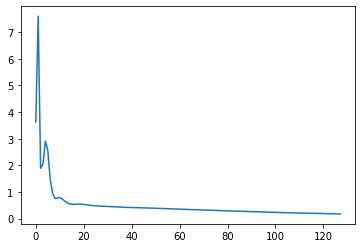

In [24]:
plt.plot(loss_history)

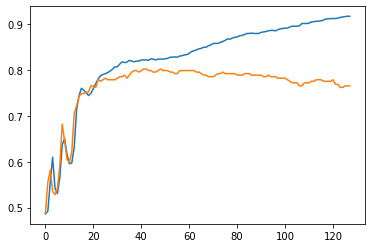

In [25]:
plt.plot(accuracy_history)
plt.plot(accuracy_test_history) # It doesn't really get better on test set than 75%,
                                # close to 80% before the end of training

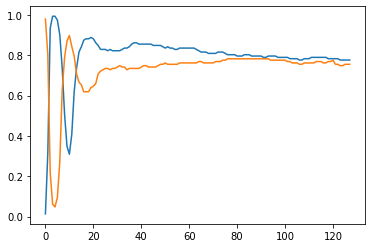

In [26]:
plt.plot(sensitivity_history)
plt.plot(specificity_history)

## Discussion of results of MLP
As excepted, the MLP naive solution caps out very quickly at 75% accuracy, which is not terrible but far from being good. There are two main problems with the current architecture :
1. Our method of turning words into numbers doesn't have any spatial relationship : words that are close to each other in the number domain have no reason to be related to one another for the purpose of detecting spam.
2. The MLP architecture has no inductive bias to work with sequences of words.

There are also minor problems that are worth addressing
1. We discarded many observations to obtain a balanced dataset, but there are better ways to handle this. We could look into *upsampling*, or changing the way we evaluate the model so that the unbalance doesn't favor guessing "ham".
2. Our tokenizer has a vocabulary size of 500 but we have more than 4000 words, which means many rare words are converted into the same token. On top of that, we truncate sentences that are longer than 50 words. **Those are general problems with the naive word embedding**, the solution is to use another method altogether, not to solve those problems one at a time.

On the bright side,  training this model is very quick and the dataset is lightweight, which means we can load all of it at the same time if needed. **Maybe we should use stochastic gradient descent regardless**.

## Trying LSTM with the current word embedder
Looking at documentation of LSTM on https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html

Inputs are of the form *input, (h_0, c_0)*, where *input* is of the form (L, input_size) *if unbatched*
Outputs are of the form *output, (h_n, c_n)*, where *output* is of the form (L, hidden_size)
So h_t and c_t are tensors containing only one number

Parameters
1. input_size = 1 : Number of features of input
2. hidden_size : Number of features of hidden cells (c_t and h_t since I take the option to not project). Taking it equal to 1 seems easiest
3. num_layers = 1 : If equal to 2, means you have two stacked LSTMs. Here I will take = 1

In [77]:
X_train.size()[0] #Input needs to be a tensor of length 50
N = X_train.size()[0]
print(N)
print(random.randint(0, N-1)) 
print(X_test.size()[0])

1195
542
299


In [72]:
print(X_train[1].size()) # Need to convert it into 50x1 I think
testTensor = X_train[1].view(-1,1,1)
print(testTensor.size())
testTensor2 = testTensor.squeeze(-1).squeeze(-1)
print(testTensor2.size())

torch.Size([50])
torch.Size([50, 1, 1])
torch.Size([50])


In [74]:
print(Y_train[1].size()) # WTF ??
Y_train[1]
print(Y_train[1].view(-1).size())

torch.Size([])
torch.Size([1])


In [88]:
epochs = 3
h0 = torch.zeros(1,1,1) # Recommended to initialize at 0
c0 = torch.zeros(1,1,1)

rnn = nn.LSTM(1,1,1) # input, hidden, num_layers
                     # Note that h_n is in [-1,1] so we need to apply a sigmoid to h_n
criterion = nn.BCELoss()
optimizer = optim.Adam(rnn.parameters(), lr=.01)

loss_history_rnn = [] # Computed after each iteration
accuracy_history_rnn = []
accuracy_test_history_rnn = []
N = X_train.size()[0] # 1195 observations
N2 = X_test.size()[0] # 299

for i in range(epochs):
    train_correct = 0.0
    for j in range(N): # Batch size = 1
        #Forward pass
        line = random.randint(0, N-1) # Both bounds included
        output, (hn, cn) = rnn(X_train[line].view(-1,1,1), (h0, c0))
        proba_pred = torch.sigmoid(hn)
        proba_pred = proba_pred.squeeze(-1).squeeze(-1) # hn is 1x1x1
        
        # Computing loss and one iteration gradient step
        optimizer.zero_grad() 
        loss = criterion(proba_pred, Y_train[line].view(-1))
        loss_history_rnn.append(loss.item())
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            Y_pred = proba_pred > 0.5  # Binary label
            train_correct += (Y_train[line].view(-1) == Y_pred).float()

    # After each epoch : compute model accuracy
    with torch.no_grad():
        accuracy = train_correct / N
        accuracy_history_rnn.append(accuracy)
        
        test_correct = 0.0
        for j in range(N2):
            output2, (hn2, cn2) = rnn(X_test[j].view(-1,1,1), (h0, c0))
            proba_pred_test = torch.sigmoid(hn2)
            proba_pred_test = proba_pred_test.squeeze(-1).squeeze(-1)
            
            Y_pred_test = proba_pred_test > 0.5
            test_correct += (Y_test[j].view(-1) == Y_pred_test).float()
        
        accuracy_test = test_correct / N
        accuracy_test_history_rnn.append(accuracy_test)
    
    print("Epoch {epo} done".format(epo=i+1))

Epoch 1 done
Epoch 2 done
Epoch 3 done


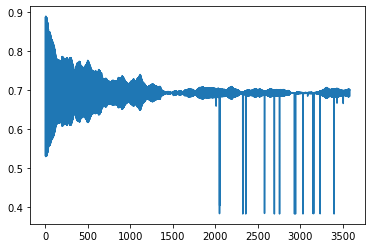

In [89]:
plt.plot(loss_history_rnn) # Yeah, something has gone horribly wrong

In [90]:
# The accuracies are very poor
print(accuracy_history_rnn)
print(accuracy_test_history_rnn)

[tensor([0.5088]), tensor([0.5013]), tensor([0.5071])]
[tensor([0.1230]), tensor([0.1230]), tensor([0.1230])]


# Discussion of LSTM results
The training is significantly slower. I think that is largely due to my implementation that is fairly "manual" and the fact that I don't use mini-batches. Also having to fiddle around with tensor dimensions is really annoying.

Well, it doesn't work with the current implementation of word embedder. Maybe there's something wrong with my implementation of LSTM as well, but it's pointless looking further without a solid word embedder.